# Requirements

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

# Dataset loader

In [2]:
train_dir = './hmt_dataset/HMT_train'
test_dir = './hmt_dataset/HMT_test'

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [3]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [3]:
model.summary()

NameError: name 'model' is not defined

# Training

In [5]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.SGD(),
              metrics=['accuracy'])

In [6]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log2', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [ ]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    epochs=150,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)

In [ ]:
model.save('HMT.h5')

# Load Model

In [46]:
model=load_model('HMT.h5')

In [47]:
def my_summary_iterator(path):
  for r in tf_record.tf_record_iterator(path):
    yield event_pb2.Event.FromString(r)
train_acc = []
train_loss = []
train_lr = []

for e in my_summary_iterator('./log2/train/' + os.listdir('./log2/train')[-1]):
  for v in e.summary.value:
    if v.tag == 'epoch_accuracy':
      train_acc.append(v.simple_value)
    elif v.tag == 'epoch_loss':
      train_loss.append(v.simple_value)

Text(0.5, 1.0, 'Training progress: Accuracy')

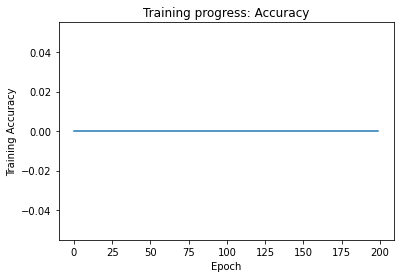

In [48]:
plt.plot(np.arange(len(train_acc)), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training progress: Accuracy')

Text(0.5, 1.0, 'Training progress: Loss')

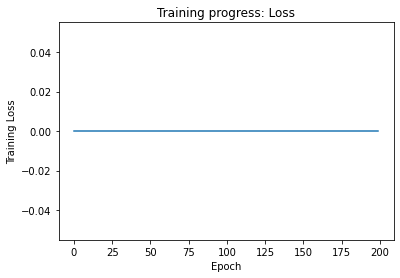

In [49]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training progress: Loss')

# Plotting to evaluate 

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

test_generator.reset()
y_test=test_generator.classes
y_pred=model.predict(test_generator)
y_predicted=np.argmax(y_pred, axis=1)
print('Overall classification accuracy for all classes:'+str(np.sum(y_predicted==y_test)/y_test.shape[0]))

Overall classification accuracy for all classes:0.8306451612903226


In [51]:
for i in range(8):
    true_i=np.where(y_test==i)[0]
    res=0
    for j in true_i:
        if y_predicted[j]==i:
            res=res+1
    print('class '+str(i)+' accuracy:'+str(res/true_i.shape[0]))

class 0 accuracy:0.9193548387096774
class 1 accuracy:0.8709677419354839
class 2 accuracy:0.5967741935483871
class 3 accuracy:0.8870967741935484
class 4 accuracy:0.45161290322580644
class 5 accuracy:0.9516129032258065
class 6 accuracy:0.967741935483871
class 7 accuracy:1.0


AUC for class 0:  0.9948714137059611


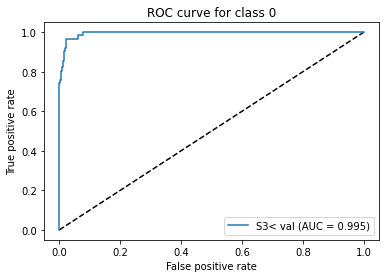

AUC for class 1:  0.9665526980823547


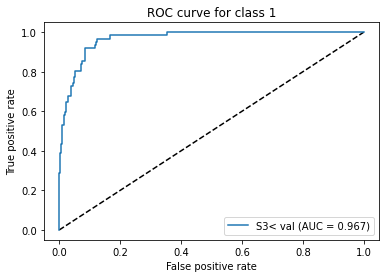

AUC for class 2:  0.9670358257767206


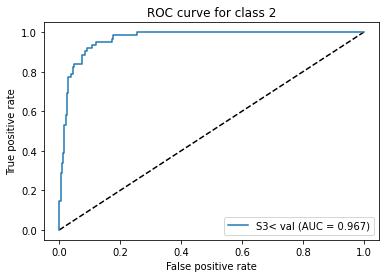

AUC for class 3:  0.9882562806600268


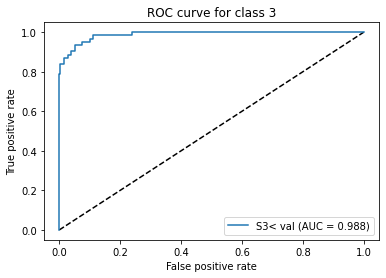

AUC for class 4:  0.9813066745949159


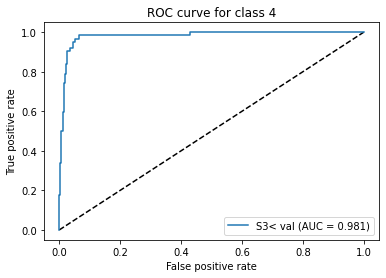

AUC for class 5:  0.9920098112085625


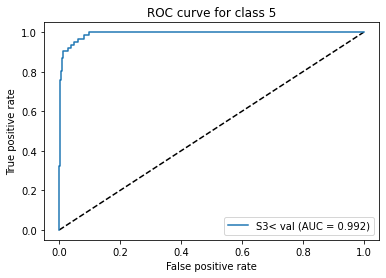

AUC for class 6:  0.9997770179872156


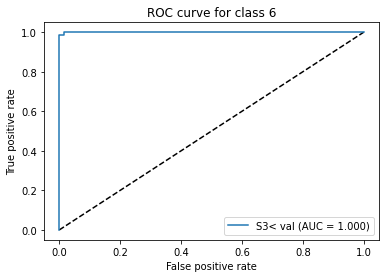

AUC for class 7:  0.9998885089936078


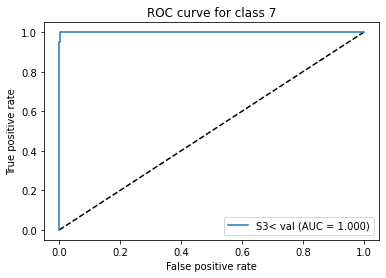

In [52]:
real_y=np.zeros((y_test.size,8))
for i in range(y_test.size):
    real_y[i,y_test[i]]=1
for i in range(8):
    FPR, TPR, thresholds_keras = roc_curve(real_y[:,i], y_pred[:,i]) 
    AUC = auc(FPR, TPR)  
    print("AUC for class "+str(i)+": ", AUC)
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(FPR, TPR, label='S3< val (AUC = {:.3f})'.format(AUC))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for class '+str(i))
    plt.legend(loc='best')
    plt.show()    

# Explanation

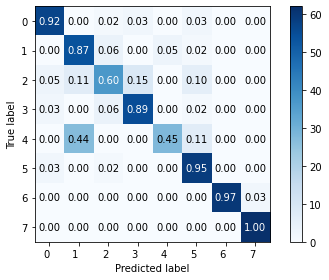

In [53]:
cm=confusion_matrix(list(y_test),list(y_predicted))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
classes=[0,1,2,3,4,5,6,7]
# print(classes)
# We want to show all ticks...
ax.set(xticks=np.arange(cm_normalized.shape[1]),
       yticks=np.arange(cm_normalized.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(),  ha="right",
             rotation_mode="anchor")
thresh = cm_normalized.max() / 2.
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        ax.text(j, i, format(cm_normalized[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cm_normalized[i, j] > thresh else "black")
fig.tight_layout()


In [54]:
print(classification_report(y_true=y_test,y_pred=y_predicted))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90        62
           1       0.61      0.87      0.72        62
           2       0.79      0.60      0.68        62
           3       0.83      0.89      0.86        62
           4       0.90      0.45      0.60        62
           5       0.78      0.95      0.86        62
           6       1.00      0.97      0.98        62
           7       0.97      1.00      0.98        62

    accuracy                           0.83       496
   macro avg       0.85      0.83      0.82       496
weighted avg       0.85      0.83      0.82       496



Load the explaier library

In [55]:
from xai_utils import *
from xai_methods import *

Load a batch of images

In [56]:
test_generator.reset()

In [57]:
image_batch,label_batch=test_generator.next()

Classes:

In [58]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

Predict a single image

In [90]:
index=8

In [91]:
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.9391455


Generate explanation map

## SISE (Semantic Input Sampling for Explanation)

Set the layer(s)

In [61]:
layers=[['conv2d_3']]

In [62]:
%%time
explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
explanation_map_SISE -= explanation_map_SISE.min()
explanation_map_SISE /= explanation_map_SISE.max()+10e-30

CPU times: total: 4.84 s
Wall time: 839 ms


## Grad-CAM (Gradient-based Class Activation Mapping)

In [63]:
%%time
explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
explanation_map_GradCAM -= explanation_map_GradCAM.min()
explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

CPU times: total: 906 ms
Wall time: 227 ms


## Grad-CAM++

In [64]:
%%time
explanation_map_GradCAMPP = grad_cam_plus_plus(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
explanation_map_GradCAMPP -= explanation_map_GradCAMPP.min()
explanation_map_GradCAMPP /= explanation_map_GradCAMPP.max()+10e-30

CPU times: total: 219 ms
Wall time: 222 ms


In [65]:
%%time
explanation_map_LIME = LIME_2d(image_batch[index], model, np.argmax(label_batch[index]), num_perturb=300, kernel_size=4,max_dist=200, ratio=0.2, kernel_w=0.25, num_feats=10)
explanation_map_LIME -= explanation_map_LIME.min()
explanation_map_LIME /= explanation_map_LIME.max()+10e-30

CPU times: total: 37.6 s
Wall time: 15.4 s


## Ablation-CAM

In [66]:
%%time

explanation_map_ablation_cam = ablation_cam_2d(model, np.expand_dims(image_batch[index], axis=0), 'conv2d_3')
explanation_map_ablation_cam -= explanation_map_ablation_cam.min()
explanation_map_ablation_cam /= explanation_map_ablation_cam.max()+10e-30
# return explanation

CPU times: total: 8.83 s
Wall time: 3.25 s


## RISE (Randomized Input Sampling for Explanation)

In [67]:
%%time
explanation_map_RISE = RISE(image_batch[index], model, class_index=np.argmax(prediction[index]) ,N_MASKS=1000)
# explanation_map_RISE -= explanation_map_RISE.min()
# explanation_map_RISE /= explanation_map_RISE.max()+10e-30

CPU times: total: 1min 56s
Wall time: 17.4 s


## Plot the results

20


Text(0.5, 1.0, 'Explanation map (RISE)')

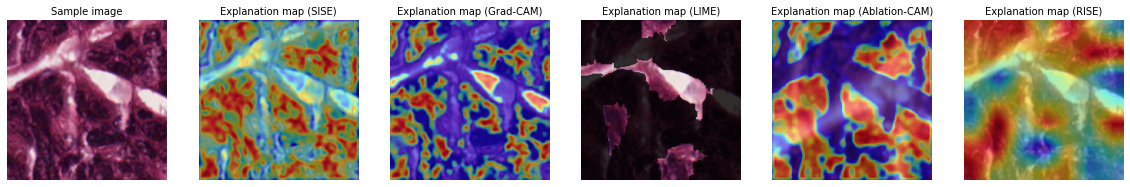

In [68]:
plt.figure(figsize=(20,5))
print(index)

plt.subplot(1,6,1)
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Sample image', fontsize=10)

plt.subplot(1,6,2)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_SISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (SISE)', fontsize=10)

plt.subplot(1,6,3)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM)', fontsize=10)

plt.subplot(1,6,4)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_LIME, cmap='jet', alpha=0.8)
plt.axis('off')
plt.title('Explanation map (LIME)', fontsize=10)

plt.subplot(1,6,5)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_ablation_cam, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Ablation-CAM)', fontsize=10)

plt.subplot(1,6,6)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_RISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (RISE)', fontsize=10)

## Quantitative evaluation of the explanation algorithm

In [69]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [70]:
test_generator.reset()
drop_rate = 0.
increase_rate = 0.
for i in range(15):
    image_batch,label_batch=test_generator.next()
    # print("Current Round:", i)
    for index in range(32):
        # print(i, index)
        prediction=model(image_batch)
        explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
        res = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_GradCAM, class_index=np.argmax(prediction[index]), frac=0.9)

        drop_rate += res[0]
        increase_rate += res[1]

drop_rate /= (15*32)
increase_rate /= (15*32)
print("======Grad-CAM======")
print(drop_rate, increase_rate)

KeyboardInterrupt: 

In [ ]:
# test_generator.reset()
# drop_rate = 0.
# increase_rate = 0.
# for i in range(15):
#     image_batch,label_batch=test_generator.next()
#     print("Current Round:", i)
#     for index in range(32):
#         # print(i, index)
#         prediction=model(image_batch)
#         explanation_map_LIME = LIME_2d(image_batch[index], model, np.argmax(prediction[index]), num_perturb=300, kernel_size=4,max_dist=200, ratio=0.2, kernel_w=0.25, num_feats=10)
#         explanation_map_LIME = explanation_map_LIME[:,:,0]
#         res = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_LIME, class_index=np.argmax(prediction[index]), frac=0.9)[0:2]

#         drop_rate += res[0]
#         increase_rate += res[1]

# drop_rate /= (15*32)
# increase_rate /= (15*32)
# print("======LIME======")
# print(drop_rate, increase_rate)

In [ ]:
test_generator.reset()
drop_rate = 0.
increase = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_LIME = LIME_2d(image_batch[index], model, np.argmax(prediction[index]), num_perturb=300, kernel_size=4,max_dist=200, ratio=0.2, kernel_w=0.25, num_feats=10)
        explanation_map_LIME = explanation_map_LIME[:,:,0]
        drop_rate_add, increase_add= calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_LIME, class_index=np.argmax(prediction[index]), frac=0.9)[0:2]
        drop_rate += drop_rate_add
        increase += increase_add
drop_rate /= (15*32)
increase /= (15*32)
print(drop_rate)
print(increase)

0.8666666655271839
0.13333333333333333


In [ ]:
test_generator.reset()
drop_rate = 0.
increase_rate = 0.
for i in range(15):
    image_batch,label_batch=test_generator.next()
    # print("Current Round:", i)
    for index in range(32):
        # print(i, index)
        prediction=model(image_batch)
        explanation_map_GradCAMPP = grad_cam_plus_plus(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
        res = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_GradCAMPP, class_index=np.argmax(prediction[index]), frac=0.9)

        drop_rate += res[0]
        increase_rate += res[1]

drop_rate /= (15*32)
increase_rate /= (15*32)
print("======Grad-CAM-PLUSPLUS======")
print(drop_rate, increase_rate)

======Grad-CAM-PLUSPLUS======
0.5092109868001297 0.19791666666666666


In [ ]:
drop_rate = 0.
increase_rate = 0.

for i in range(15):
    image_batch, label_batch = test_generator.next()
    print("Current Round:", i)
    for index in range(32):
        # print(i, index)
        prediction = model(image_batch)
        explanation_map_ablation_cam = ablation_cam_2d(
            model, np.expand_dims(image_batch[index], axis=0), 'conv2d_3')
        explanation_map_ablation_cam = cv2.resize(explanation_map_ablation_cam, (224, 224), interpolation=cv.INTER_AREA)
        res = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_ablation_cam, class_index=np.argmax(prediction[index]), frac=0.9)

        drop_rate += res[0]
        increase_rate += res[1]

drop_rate /= (15 * 32)
increase_rate /= (15 * 32)
print("======Ablation-CAM======")
print(drop_rate, increase_rate)

Current Round: 0


IndexError: index 16 is out of bounds for axis 0 with size 16